<a href="https://colab.research.google.com/github/deepakjayakumar/TensorFlow_project_1/blob/main/god_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
#!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')


## 1. Problem

Identifying the breed of the dog in the giiven photo

## 2. Data

The data was taken from Kaggle dog breed database

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evealuation is a file with prediction probabilities of each dog breed of each test image

## 4. Features

Some information about the data:
* We are dealing with images (unstructured data) so its probabaly best we use deep learning
* There are 120 breeds of dog (Multi class classification)
* There are 10,000+ images in train set (these images have labels)
* There are 10,000+ images in the test set (these images dont have labels and we will want to predict it)

In [4]:
# Unzip the uploaded data in Google cloud
#!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

### Get your workspace ready

In [5]:
# Import tensorflow in colab
import tensorflow as tf
print('Tensor version: ',tf.__version__)

Tensor version:  2.17.0


In [6]:
import tensorflow_hub as hub
print("TF hub version : ", hub.__version__)

# Check for GPU availability
print("GPU"," availabile" if tf.config.list_physical_devices("GPU") else "not available")

TF hub version :  0.16.1
GPU  availabile


# Getting our data ready

With all machine learning models our data should be in numeric. So we will be turining our images into tensors (numerical representation)

Lets start by acccesing our data anc checking out the labels

In [7]:
# check out the data of our labels
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [10]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: xlabel='breed'>

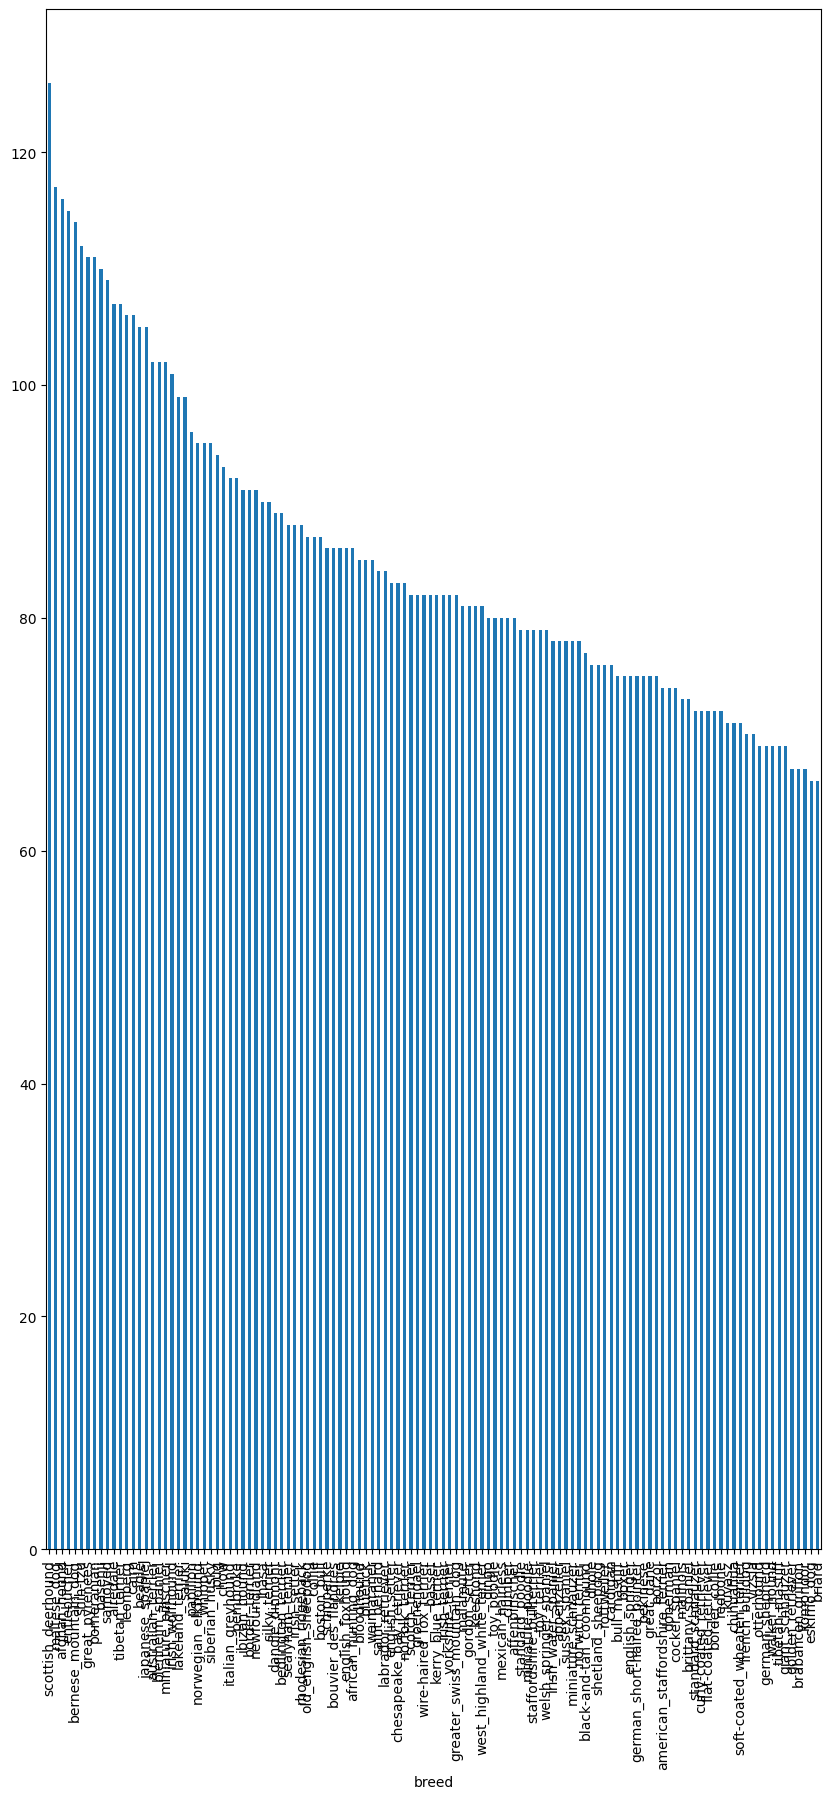

In [11]:
# How many counts are there with each breed?

labels_csv["breed"].value_counts().plot.bar(figsize=(10,20))

In [12]:
labels_csv["breed"].value_counts().median()

82.0

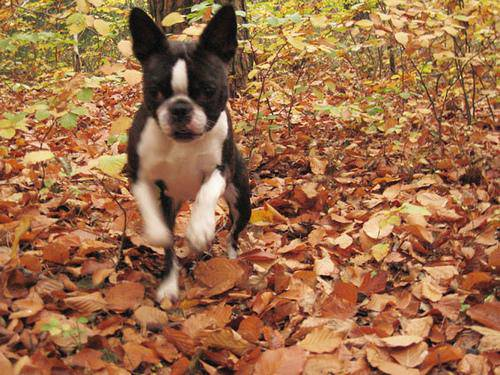

In [13]:
# Lets view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Lets get a list of all our images file pathname

In [14]:
# Create file pathnames from Image ID's

# filenames = [fname for fname in labels_csv["id"].values]
filenames = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"].values]
#filenames


In [15]:
#Check whether number of file names matches with number of Images
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("Number of file names matches the number of image files")

Number of file names matches the number of image files


In [16]:
len(os.listdir("drive/MyDrive/Dog Vision/train/"))

10222

In [17]:
len(filenames)

10222

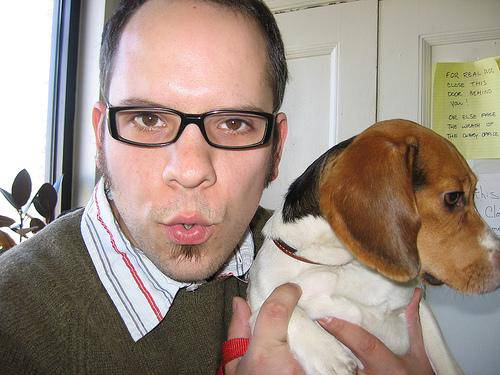

In [18]:
Image(filenames[8041])

Since we got our training file paths, lets prepare our labels

In [19]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [20]:
len(labels)

10222

In [21]:
# find the unique label values
unique_breeds  = np.unique(labels)
len(unique_breeds)

120

In [22]:
# Turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
# Example : Turining boolean array into integers
print(labels[500]) #original Label
print(np.where(unique_breeds == labels[500])) # index where label occurs
print(boolean_labels[500].argmax()) # index where label occurs in boolean array
print(boolean_labels[500].astype(int)) # there will be a 1 where smaple label occurs

otterhound
(array([83]),)
83
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesnot contain the vaidation set we are creating it on our own

In [24]:
# Creating X and y variables
X = filenames
y = boolean_labels

In [25]:
len(X), len(y)

(10222, 10222)

We are going to start with -1000 images and increase when needed


In [26]:
# Set the number of images to be used for the experiment
NUM_IMAGES = 1000 #@param {type:"slider", min:1000,max:10000,step:100}

In [28]:
# Split our data into train and validation
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=2)
len(X_train),len(X_val),len(y_train),len(y_val)

(800, 200, 800, 200)

In [34]:
# prompt: Lets have a geez at the training data

# Lets view an image
print(X_train[0])
Image(X_train[0])
Image(filenames[0])
print(y_train[0].astype(int))
print(unique_breeds[y_train[0].argmax()])


drive/MyDrive/Dog Vision/train/041d0d6a8d110b35a3795dd5c68f9a36.jpg
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
american_staffordshire_terrier


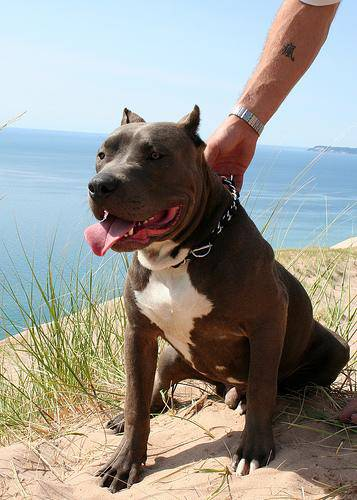

In [35]:
Image(X_train[0])